In [1]:
from pv_analyzer import pv_analyze
import numpy as np
import Tb_estimator as tb_est
from lteanalysis import LTEAnalysis
import corner
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
%matplotlib widget

## Rs with empkep

In [3]:
#res_prefix = 'rs_empkep_fixr_rms_SLAM_vcut_lwerN_bnds_high_tbnds_sf_bf' # t1 -- > Normal results with corrections, t0 before corrections

### Some functions

In [4]:
def emp_kep_v(v_rot, v_100, p):        
        r_au = 100.*np.power(v_100/v_rot, 1/p)
        return r_au

def emp_kep_r(r,r_b, v_100, p):
        v_r = v_100*(r/100)**(-p)
        return v_r

In [5]:
def bff_function(a,p,r):

    return 1. - np.exp(- a * np.power(r,p))

def beam_dilution_correction(Tb, r, Tb_err):

    a = 1.1321e-01
    p = 1.8575e+00
    bff_err = 0.09
    bff = bff_function(a,p,r)
    
    Tb_corrected = Tb/bff
    Tb_corr_err = np.sqrt((Tb_err/bff)**2 + bff_err**2)

    return Tb_corrected, Tb_corr_err, bff, bff_err

In [6]:
# constants (in cgs)
from astropy import constants, units

Ggrav  = constants.G.cgs.value        # Gravitational constant
ms     = constants.M_sun.cgs.value    # Solar mass (g)
ls     = constants.L_sun.cgs.value    # Solar luminosity (erg s^-1)
rs     = constants.R_sun.cgs.value    # Solar radius (cm)
au     = units.au.to('cm')            # 1 au (cm)
pc     = units.pc.to('cm')            # 1 pc (cm)
clight = constants.c.cgs.value        # light speed (cm s^-1)
kb     = constants.k_B.cgs.value      # Boltzman coefficient
hp     = constants.h.cgs.value        # Planck constant
sigsb  = constants.sigma_sb.cgs.value # Stefan-Boltzmann constant (erg s^-1 cm^-2 K^-4)
mp     = constants.m_p.cgs.value      # Proton mass (g) 


def IvTOTex(Iv, nu0, bmaj, bmin, sigI=None):
    '''
    Convert Iv to Tb WITHOUT Rayleigh-Jeans approximation.

    Parameters
    ----------
        nu0 (float): Rest frequency [Hz]
        bmaj (float): Major beam size [deg]
        bmin (float): Minor beam size [deg]
        Iv (array or float): Intensity [Jy/beam]
        sigI (array or float): Sigma of intensity [Jy/beam]

    Others
    ------
        C1: coefficient to convert Iv to Tex
        C2: coefficient to convert beam to str
    '''

    bmaj = bmaj*np.pi/180. # deg --> radian
    bmin = bmin*np.pi/180. # deg --> radian

    C1=2.*hp*(nu0*nu0*nu0)/(clight*clight) # in cgs

    # Jy/beam -> Jy/str
    # Omg_beam (str) = (pi/4ln(2))*beam (rad^2)
    # I [Jy/beam] / Omg_beam = I [Jy/str]
    C2 = np.pi/(4.*np.log(2.))  # beam(rad) -> beam (sr)
    bTOstr = bmaj*bmin*C2  # beam --> str
    Istr = Iv/bTOstr # Jy/beam --> Jy/str
    Istr = Istr*1.0e-26 # Jy --> MKS (Jy = 10^-26 Wm-2Hz-1)
    Istr = Istr*1.e7*1.e-4 # MKS --> cgs

    Tex = (hp*nu0/kb)/(np.log(C1/Istr + 1.)) # no approximation [K]

    if sigI is not None:
        # Error propagation
        dT_dI = (hp*nu0/kb) * C1 * (Istr**(-2.)) * (C1/Istr + 1.)**(-1.) \
        * (np.log(C1/Istr + 1.))**(-2) # derivative
        sigI_str = sigI / bTOstr * 1.0e-26 * 1.e7 * 1.e-4
        sigTex = np.sqrt(dT_dI*dT_dI*sigI_str*sigI_str)

        return Tex, sigTex
    else:
        return Tex
    
def IvTOJT(Iv, nu0, bmaj, bmin):
    '''
    Calculate the equivalent brightness temperature from intensity in a unit of Jy/beam.

    Input
     nu0: rest frequency [Hz]
     bmaj: major beam size [deg]
     bmin: minor beam size [deg]
     Iv: intensity [Jy/beam]

    Others
     C2: coefficient to convert beam to str
     JT: equivalent brightness temperature [K]
    '''
    bmaj = bmaj*np.pi/180. # deg --> radian
    bmin = bmin*np.pi/180. # deg --> radian

    # Jy/beam -> Jy/sr
    # Omg_beam (sr) = (pi/4ln(2))*beam (rad^2)
    # I [Jy/beam] / Omg_beam = I [Jy/sr]
    C2 = np.pi/(4.*np.log(2.))  # beam(rad) -> beam (sr)
    bTOstr = bmaj*bmin*C2  # beam --> str
    Istr = Iv/bTOstr # Jy/beam --> Jy/str
    Istr = Istr*1.0e-26 # Jy --> MKS (Jy = 10^-26 Wm-2Hz-1)
    Istr = Istr*1.e7*1.e-4 # MKS --> cgs

    JT = (clight*clight/(2.*nu0*nu0*kb))*Istr # equivalent brightness temperature
    return JT


#### Read the Data

In [7]:
v_sys_b6=7.386 #kmps
v_100_b6 = 2.797
p_index_b6 = 0.511

v_sys_b7=7.289
v_100_b7 =2.811
p_index_b7 = 0.464

v_sys_avg = (v_sys_b6+v_sys_b7)/2
print(v_sys_avg)
v_100_avg = (v_100_b7 + v_100_b6)/2
print(v_100_avg)
p_index_avg = (p_index_b6 + p_index_b6)/2
print(p_index_avg)


# Read b7 data
pv_b7_in_BT = pv_analyze(pv_path='uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_69_w1.fits',
                    is_Tb=True, v_sys=v_sys_avg) # V_sys - 7.22, 7.27 7.384
pv_b7_in_BT.read_pv(print_details = True)

# Read b7 data
pv_b7_in_Iv = pv_analyze(pv_path='uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_69_w1.fits',
                    is_Tb=False, v_sys=v_sys_avg) # V_sys - 7.22, 7.27 7.384
pv_b7_in_Iv.read_pv(print_details = True)



7.3375
2.8040000000000003
0.511
Convert frequency to velocity
 rms = 3.45e-02 Jy beam$^-1$
 rms = 1.08 K
Convert frequency to velocity
 rms = 3.45e-02 Jy beam$^-1$


In [8]:
# define fix r points
# Get equidistance points

r_au_empkep_rs_fix_r = np.arange(start=42., step=42., stop=840.)
r_au_empkep_bs_fix_r = -r_au_empkep_rs_fix_r

v_100 = v_100_avg #kmps # idpft-2.674 # JS- 3.2 # newft 2.842

v_rot_empkep_rs_fix_r =  emp_kep_r(r=r_au_empkep_rs_fix_r, r_b=100., v_100=v_100_avg, p=p_index_avg)
v_rot_empkep_bs_fix_r = - v_rot_empkep_rs_fix_r

plot_points = [r_au_empkep_rs_fix_r, v_rot_empkep_rs_fix_r, r_au_empkep_bs_fix_r, v_rot_empkep_bs_fix_r]

In [9]:
# Evaluate empirical keplerian curve function
r_rs_func = np.arange(start=1., step=0.5, stop=840.)   # Note that this is in AU
v_rs_func = emp_kep_r(r=r_rs_func, r_b=100., v_100=v_100, p=p_index_avg)

r_bs_func = -r_rs_func
v_bs_func = -v_rs_func

In [10]:
Tb_b7_before_bff_correction = pv_b7_in_BT.get_tb_on_curve(curve_function = plot_points, 
                                get_surrounding_pix = False, mode='vals',
                                num_pix = 3)
Iv_b7_before_bff_correction = pv_b7_in_Iv.get_tb_on_curve(curve_function = plot_points, 
                                    get_surrounding_pix = False, mode='vals',
                                    num_pix = 3)

### Calculation

[3.29330540e+11 3.29330541e+11 3.29330542e+11 3.29330542e+11
 3.29330542e+11 3.29330543e+11 3.29330543e+11 3.29330543e+11
 3.29330543e+11 3.29330543e+11 3.29330543e+11 3.29330543e+11
 3.29330543e+11 3.29330543e+11 3.29330543e+11 3.29330543e+11
 3.29330543e+11 3.29330543e+11 3.29330543e+11]


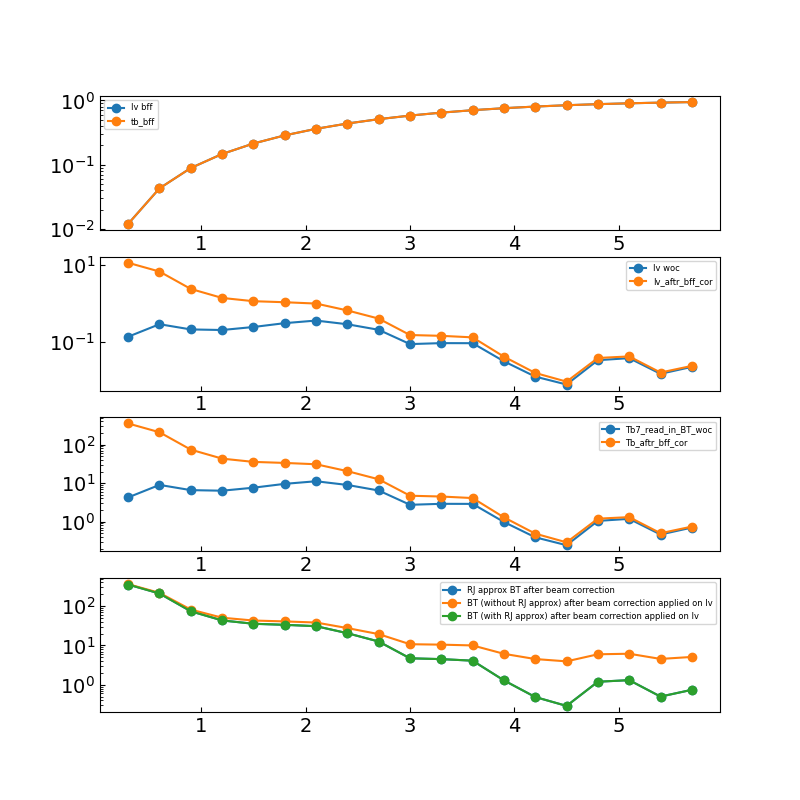

In [21]:

Tb7_read_in_BT_woc  = Tb_b7_before_bff_correction["Tb_on_point_rs"]
r_Tb7_read_in_BT = Tb_b7_before_bff_correction["r_rs"]

Iv_read_in_Jy_woc = Iv_b7_before_bff_correction["Tb_on_point_rs"]
r_Iv_read_in_Jy = Iv_b7_before_bff_correction["r_rs"]



# Beam filling factor correction
Iv_aftr_bff_cor, iv_er,iv_bff, iv_bff_err = beam_dilution_correction(Tb=Iv_read_in_Jy_woc, r = r_Iv_read_in_Jy, 
                                           Tb_err = 3.45e-2*np.ones_like(np.array(r_Iv_read_in_Jy)))

Tb_aftr_bff_cor, tb_er, tb_bff, tb_bff_err = beam_dilution_correction(Tb=Tb7_read_in_BT_woc, r = r_Tb7_read_in_BT, 
                                           Tb_err = 1.01*np.ones_like(np.array(r_Iv_read_in_Jy)))

# Convert Iv to brightness temperature
Iv_nu = (1 - ((pv_b7_in_Iv.v_rot_redshifted+v_sys_avg)/3e8))*329.3305525e9

print(Iv_nu)

Tb_Iv_nu = []
for inu, nu in zip(Iv_aftr_bff_cor,  Iv_nu): 
    Tb_Iv_nu.append(IvTOTex(Iv=inu, nu0 =nu, bmaj = 0.6/3600, bmin = 0.6/3600))

Tb_Iv_nu_RJ = []
for inu, nu in zip(Iv_aftr_bff_cor,  Iv_nu): 
    Tb_Iv_nu_RJ.append(IvTOJT(Iv=inu, nu0 =nu, bmaj = 0.6/3600, bmin = 0.6/3600))


fig, axs = plt.subplots(4, figsize=(8,8))
axs[0].plot(r_Tb7_read_in_BT, iv_bff, label='Iv bff', marker='o')
axs[0].plot(r_Iv_read_in_Jy, tb_bff, label='tb_bff', marker='o')
axs[0].legend(prop={'size': 6})
axs[0].set_yscale('log')

axs[1].plot(r_Tb7_read_in_BT, Iv_read_in_Jy_woc, label='Iv woc', marker='o')
axs[1].plot(r_Iv_read_in_Jy, Iv_aftr_bff_cor, label='Iv_aftr_bff_cor', marker='o')
axs[1].legend(prop={'size': 6})
axs[1].set_yscale('log')

axs[2].plot(r_Tb7_read_in_BT, Tb7_read_in_BT_woc, label='Tb7_read_in_BT_woc', marker='o')
axs[2].plot(r_Tb7_read_in_BT, Tb_aftr_bff_cor, label='Tb_aftr_bff_cor', marker='o')
axs[2].legend(prop={'size': 6})
axs[2].set_yscale('log')

axs[3].plot(r_Tb7_read_in_BT, Tb_aftr_bff_cor, label='RJ approx BT after beam correction', marker='o')
axs[3].plot(r_Iv_read_in_Jy, Tb_Iv_nu, label='BT (without RJ approx) after beam correction applied on Iv', marker='o')
axs[3].plot(r_Iv_read_in_Jy, Tb_Iv_nu_RJ, label='BT (with RJ approx) after beam correction applied on Iv', marker='o')
axs[3].legend(prop={'size': 6})
axs[3].set_yscale('log')



#### Data Visualization

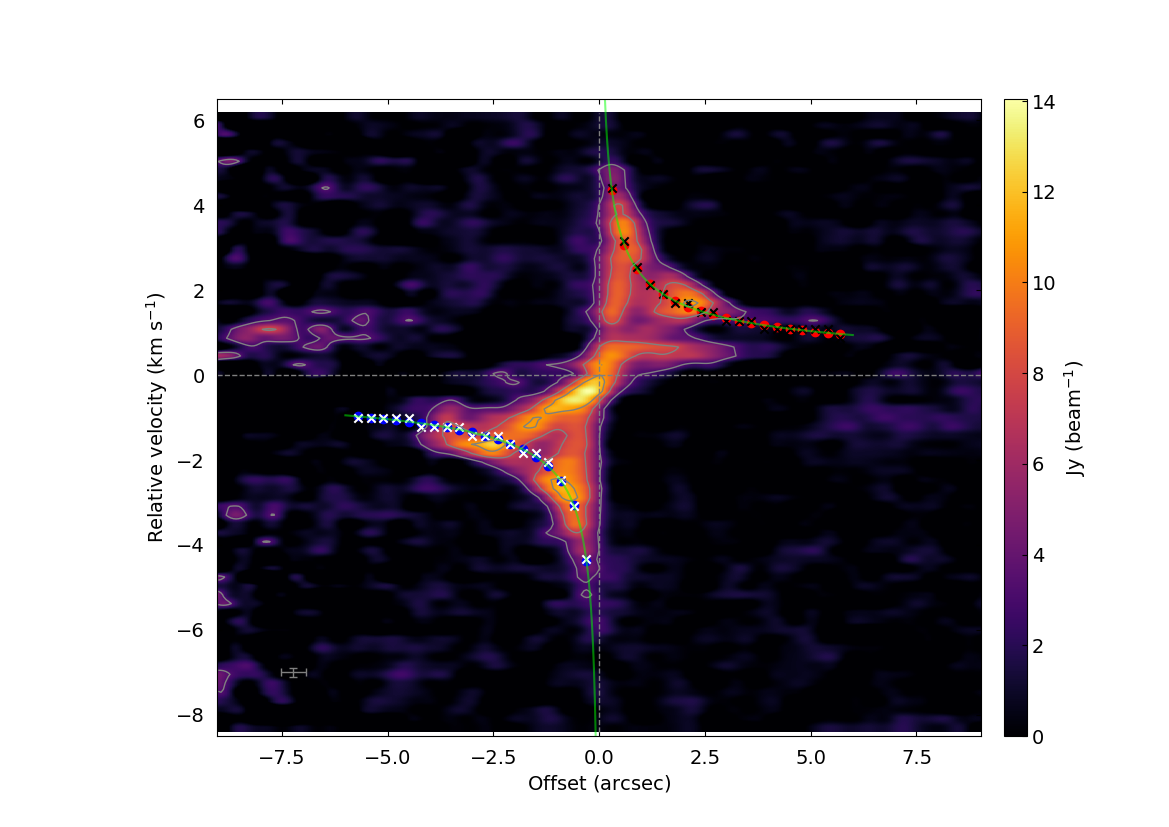

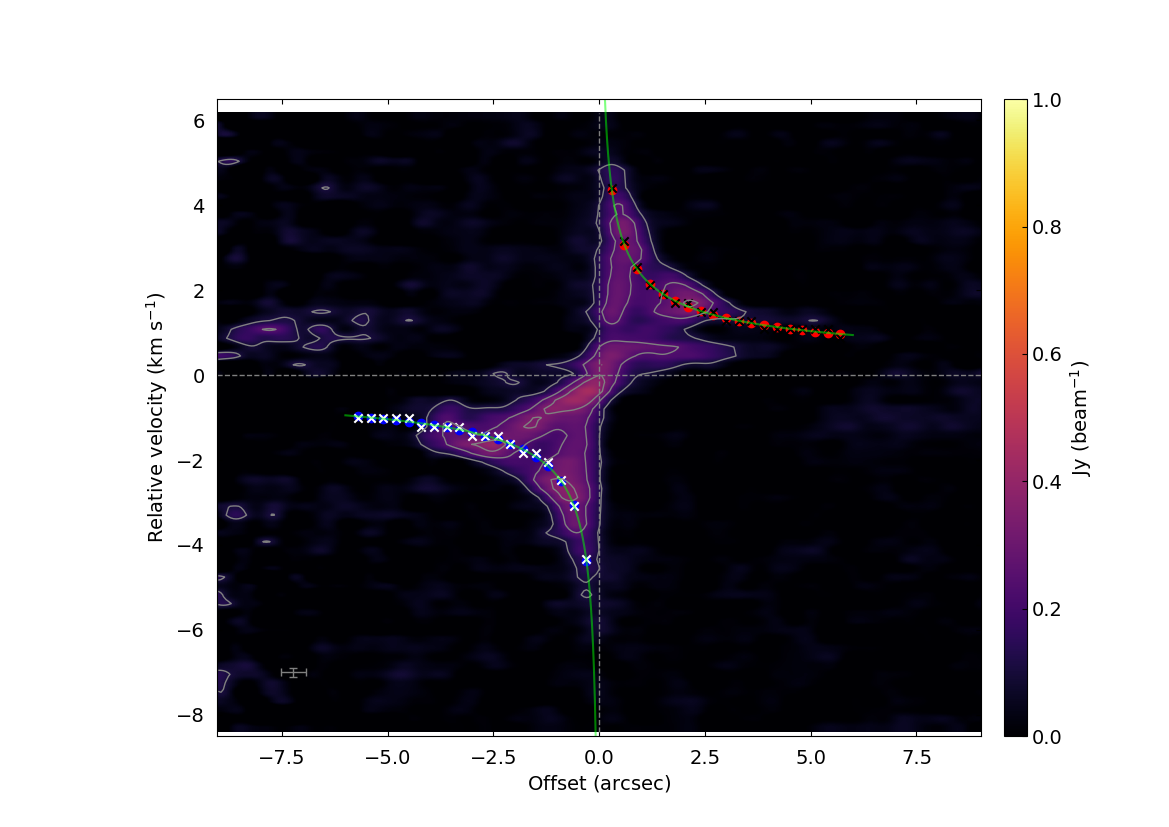

In [13]:

pv_b7_in_BT_dia = pv_b7_in_BT.plot_pv(plot_curve=True)
pv_b7_in_BT_dia[0].plot(r_rs_func/140.,v_rs_func,color = 'lime', alpha = 0.5)
pv_b7_in_BT_dia[0].plot(r_bs_func/140.,v_bs_func,color = 'lime', alpha = 0.5)

pv_b7_in_Iv_dia = pv_b7_in_Iv.plot_pv(plot_curve=True, cbarlim=[0,1])
pv_b7_in_Iv_dia[0].plot(r_rs_func/140.,v_rs_func,color = 'lime', alpha = 0.5)
pv_b7_in_Iv_dia[0].plot(r_bs_func/140.,v_bs_func,color = 'lime', alpha = 0.5)

#### T estimation loop (fix r)

In [15]:
beam_filling_factor_tb6 = []
beam_filling_factor_tb6_err = []
beam_filling_factor_tb7 = []
beam_filling_factor_tb7_err = []

ctr = 0

for Tb7, Tb6, r, v in zip(Tb_df_b7["Tb_on_point_rs"][0:2], Tb_df_b6["Tb_on_point_rs"][0:2], 
                          pv_b6.r_as_rs[0:2], pv_b6.v_rot_redshifted[0:2]):

     Tb7_corrected, Tb7_err, bff_tb7, bff_tb7_err = beam_dilution_correction(Tb = float(Tb7), r=abs(float(r)), Tb_err=1.08)
     Tb6_corrected, Tb6_err, bff_tb6, bff_tb6_err = beam_dilution_correction(Tb = float(Tb6), r=abs(float(r)), Tb_err=0.49)

    


estimating for r = 3.000e-01 arcsec, v =  4.37 Kmps , Tb7 = 4.3, Tb6 = 3.6,
           Tb7_corrected = 353.7, Tb6_corrected = 297.9


In [18]:
# Calculate errorbars

T_err_empkep_rs_fix_r = [np.array(Texe_rs_empkep_fix_r)-np.array(Texe_lq_empkep_fix_r),
                         np.array(Texe_upq_empkep_fix_r)-np.array(Texe_rs_empkep_fix_r)] 

N_err_empkep_rs_fix_r = [np.array(Ncol_rs_empkep_fix_r)-np.array(Ncol_lq_empkep_fix_r), 
                         np.array(Ncol_upq_empkep_fix_r)-np.array(Ncol_rs_empkep_fix_r)]

In [19]:
# Prepare result arrays
Tb6_prediction_median = [tupple[0] for tupple in Tb_6_predictions]
Tb6_prediction_errs = [tupple[1] for tupple in Tb_6_predictions]
Tau_nu_b6 = [tupple[2] for tupple in Tb_6_predictions]
Tau_nu_errs_b6 = [tupple[3] for tupple in Tb_6_predictions]

Tb7_prediction_median = [tupple[0] for tupple in Tb_7_predictions]
Tb7_prediction_errs = [tupple[1] for tupple in Tb_7_predictions]
Tau_nu_b7 = [tupple[2] for tupple in Tb_7_predictions]
Tau_nu_errs_b7 = [tupple[3] for tupple in Tb_7_predictions]

In [22]:
results_data_fix_r = {"r_empkep_rs_fix_r": pv_b6.r_as_rs,
        "Tb7_empkep_rs_fix_r" : Tb_df_b7["Tb_on_point_rs"],
        "Tb7_empkep_rs_fix_r_prediction": Tb7_prediction_median, 
        "Tb7_empkep_rs_err_qtl_err" : Tb7_prediction_errs,
        "Tb6_empkep_rs_fix_r" : Tb_df_b6["Tb_on_point_rs"],
        "Tb6_empkep_rs_fix_r_prediction": Tb6_prediction_median,
        "Tb6_empkep_rs_err_qtl_err" : Tb6_prediction_errs,
        "Texe_rs_empkep_fix_r" : Texe_rs_empkep_fix_r, 
        "Texe_err_rs_empkep_fix_r" : np.array(T_err_empkep_rs_fix_r).T.tolist(),
        "Ncol_rs_empkep_fix_r" : Ncol_rs_empkep_fix_r, 
        "Ncol_err_rs_empkep_fix_r" : np.array(N_err_empkep_rs_fix_r).T.tolist(),
        "Tau_nu_b6" : Tau_nu_b6,
        "Tau_nu_errs_b6" : Tau_nu_errs_b6,
        "Tau_nu_b7" : Tau_nu_b7,
        "Tau_nu_errs_b7" : Tau_nu_errs_b7
        }
results_df_fix_r = pd.DataFrame(data = results_data_fix_r)

res_path = os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv")
print(res_path)
if not os.path.exists(res_path):

        df = pd.DataFrame(results_df_fix_r)
        df.to_csv(res_path, index=False)

existing_results = pd.read_csv(res_path)

updated_results = pd.concat([existing_results, results_df_fix_r], axis=1)

updated_results.to_csv(path_or_buf= res_path)

d:\L1489_IRS_ssp\LTEAnalysis\rs_empkep_fixr_rms_newcurve_lwerN_bnds_high_tbnds_sf.csv


#### Visualize results

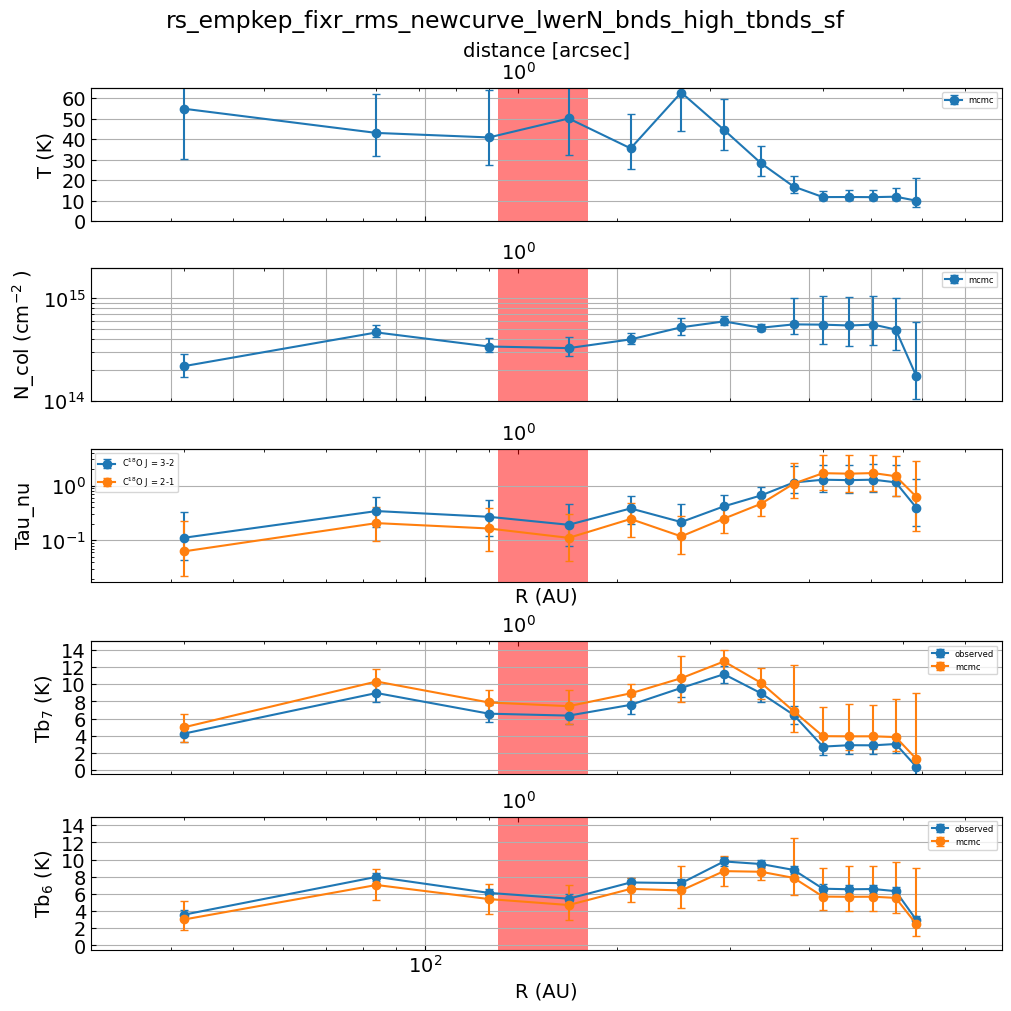

In [21]:
N_conv_fraction = 1.
vis_results_fig, axes = plt.subplots(5, figsize=(10, 10), sharex=True, layout="constrained")


acceptable_r_range = [0.3, 4.2]

ftd_r_as_rs_fix_r, ftd_Texe_rs_empkep_fix_r, \
            ftd_Terr_rs_empkep_fix_r = zip(*filter(lambda triple: 
                                                   acceptable_r_range[0] <= triple[0] <= acceptable_r_range[1], 
                                                    zip(pv_b6.r_as_rs, Texe_rs_empkep_fix_r, 
                                                    np.array(T_err_empkep_rs_fix_r).T.tolist())))

axes[0].errorbar(np.array(ftd_r_as_rs_fix_r)*140., ftd_Texe_rs_empkep_fix_r, 
                 yerr=np.array(ftd_Terr_rs_empkep_fix_r).T, marker='o', label = 'mcmc', capsize = 3.)
axes[0].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[0].set_ylim(0,65)
axes[0].set_yticks([0,10,20,30,40,50,60])
axes[0].set_ylabel(r"T (K)")
axes[0].grid(True)
axes[0].legend(prop={'size': 6})

secax_0 = axes[0].secondary_xaxis('top', functions=(lambda x: x / 140., lambda x: 140.*x))
secax_0.set_xlabel('distance [arcsec]')

ftd_r_as_rs_fix_r, ftd_Ncol_rs_empkep_fix_r, ftd_N_err_rs_empkep_fix_r = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Ncol_rs_empkep_fix_r, np.array(N_err_empkep_rs_fix_r).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[1].errorbar(np.array(ftd_r_as_rs_fix_r)*140., np.array(ftd_Ncol_rs_empkep_fix_r)*N_conv_fraction, 
                 yerr=np.array(ftd_N_err_rs_empkep_fix_r).T*N_conv_fraction, 
                 marker='o', label = 'mcmc', capsize = 3.)
axes[1].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_ylim((1.e14,2.e15))
axes[1].grid(True, which = 'both')
axes[1].legend(prop={'size': 6})

secax_1 = axes[1].secondary_xaxis('top', functions=(lambda x: x / 140., lambda x: 140.*x))
#secax_1.set_xlabel('distance [arcsec]')


ftd_r_as_bs_fix_r, ftd_Tauvu_6_bs_empkep_fix_r, \
    ftd_Tauvu_6_bs_err_empkep_fix_r = zip(*[(r, tau_6, tau6_err) for r, tau_6, tau6_err in 
                                        zip(pv_b6.r_as_rs, Tau_nu_b6, 
                                            np.array(Tau_nu_errs_b6).tolist()) 
                                        if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

ftd_r_as_bs_fix_r, ftd_Tauvu_7_bs_empkep_fix_r, \
    ftd_Tauvu_7_bs_err_empkep_fix_r = zip(*[(r, tau_7, tau7_err) for r, tau_7, tau7_err in 
                                        zip(pv_b7.r_as_rs, Tau_nu_b7, 
                                            np.array(Tau_nu_errs_b7).tolist()) 
                                        if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[2].errorbar(np.array(ftd_r_as_rs_fix_r)*140., np.array(ftd_Tauvu_7_bs_empkep_fix_r), 
                 yerr=np.array(np.squeeze(ftd_Tauvu_7_bs_err_empkep_fix_r)).T, 
                 marker='o', label = r'C$^{18}$O J = 3-2', capsize = 3.)
axes[2].errorbar(np.array(ftd_r_as_rs_fix_r)*140., np.array(ftd_Tauvu_6_bs_empkep_fix_r), 
                 yerr=np.array(np.squeeze(ftd_Tauvu_6_bs_err_empkep_fix_r)).T, 
                 marker='o', label = r'C$^{18}$O J = 2-1', capsize = 3.)
axes[2].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[2].set_ylabel(r"Tau_nu")
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].grid(True)
axes[2].legend(prop={'size': 6})
axes[2].set_xlabel("R (AU)")
secax_2 = axes[2].secondary_xaxis('top', functions=(lambda x: x / 140., lambda x: 140.*x))

ftd_r_as_rs_fix_r, ftd_Tb7_rs_empkep_fix_r, \
    ftd_Tb7_rs_empkep_fix_r_prediction,\
    ftd_Tb7_rs_empkep_fix_r_prediction_err = zip(*[(r, Tb7, Tb7_pred, Tb7_pred_err) 
                                                   for r, Tb7, Tb7_pred, Tb7_pred_err in 
                                        zip(pv_b7.r_as_rs, Tb_df_b7["Tb_on_point_rs"], 
                                            Tb7_prediction_median,
                                            np.array(Tb7_prediction_errs).tolist()) 
                                        if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[3].errorbar(np.array(ftd_r_as_rs_fix_r)*140., ftd_Tb7_rs_empkep_fix_r, 
                 yerr=np.ones_like(ftd_Tb7_rs_empkep_fix_r) * 1.01,               
                 marker='o', label = 'observed', capsize = 3.)
axes[3].errorbar(np.array(ftd_r_as_rs_fix_r)*140., ftd_Tb7_rs_empkep_fix_r_prediction, 
                 yerr=np.array(np.squeeze(ftd_Tb7_rs_empkep_fix_r_prediction_err)).T,               
                 marker='o', label = 'mcmc', capsize = 3.)
axes[3].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[3].set_ylabel(r"Tb$_{7}$ (K)")
axes[3].set_ylim((-0.5,15))
axes[3].set_yticks([0,2,4,6,8,10,12,14])
axes[3].set_xscale('log')
axes[3].grid(True)
axes[3].legend(prop={'size': 6})
secax_3 = axes[3].secondary_xaxis('top', functions=(lambda x: x / 140., lambda x: 140.*x))


ftd_r_as_rs_fix_r, ftd_Tb6_rs_empkep_fix_r, \
    ftd_Tb6_rs_empkep_fix_r_prediction,\
    ftd_Tb6_rs_empkep_fix_r_prediction_err = zip(*[(r, Tb6, Tb6_pred, Tb6_pred_err) 
                                                   for r, Tb6, Tb6_pred, Tb6_pred_err in 
                                        zip(pv_b6.r_as_rs, Tb_df_b6["Tb_on_point_rs"], 
                                            Tb6_prediction_median,
                                            np.array(Tb6_prediction_errs).tolist()) 
                                        if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])


axes[4].errorbar(np.array(ftd_r_as_bs_fix_r)*140., ftd_Tb6_rs_empkep_fix_r, 
                 yerr=np.ones_like(ftd_Tb7_rs_empkep_fix_r) * 0.49,               
                 marker='o', label = 'observed', capsize = 3.)
axes[4].errorbar(np.array(ftd_r_as_bs_fix_r)*140., ftd_Tb6_rs_empkep_fix_r_prediction, 
                 yerr=np.array(np.squeeze(ftd_Tb6_rs_empkep_fix_r_prediction_err)).T,               
                 marker='o', label = 'mcmc', capsize = 3.)
axes[4].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[4].set_ylabel(r"Tb$_{6}$ (K)")
axes[4].set_ylim((-0.5,15))
axes[4].set_yticks([0,2,4,6,8,10,12,14])
axes[4].set_xscale('log')
axes[4].grid(True)
axes[4].legend(prop={'size': 6})
secax_4 = axes[4].secondary_xaxis('top', functions=(lambda x: x / 140., lambda x: 140.*x))

axes[4].set_xlabel("R (AU)")
axes[4].set_xlim(30,800)



vis_results_fig.suptitle(op_dir_label)

vis_results_figname =  'N_vs_r_T_vs_r.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)


if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')